<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Problem 5: DCGAN, WGAN, WGAN-GP

## Download Data

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz
!pip install wandb
!wandb login

--2024-10-17 16:45:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.134.113, 52.219.170.52, 52.219.208.0, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.134.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  6.44MB/s    in 5.3s    

2024-10-17 16:45:27 (4.76 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-17 16:45:27--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.48, 52.219.170

## Library Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [2]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: NVIDIA A100-SXM4-40GB
GPU Count: 1
GPU Memory Allocated: 0
GPU Memory Cached: 0


## Load Data

### Define FashionMNIST

In [3]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = ((np.copy(imgs) / 255) * 2 - 1).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = F.one_hot(label, num_classes=10).float().to(self.device)
            return img, label
        else:
            return img

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    label = torch.argmax(label)
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset('/content', 'train', device=device)
test = FasionMNISTDataset('/content', 'test', device=device)

traindataloader = DataLoader(torch.utils.data.ConcatDataset([train,test]), batch_size=64, shuffle=True, generator=gen)
# testdataloader = DataLoader(test, batch_size=64, shuffle=True, generator=gen)

In [5]:
len(test)

10000

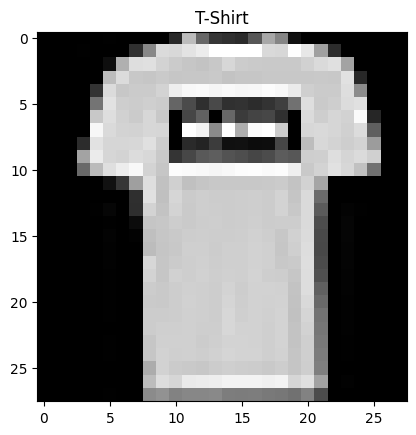

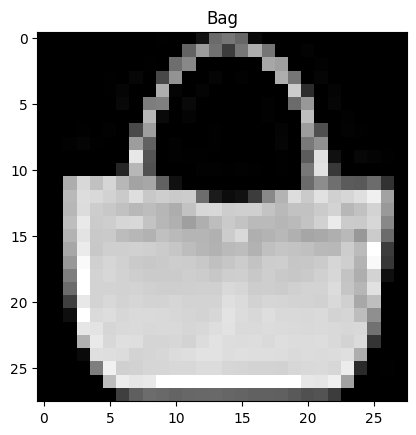

In [6]:
show_img(train, 1)
show_img(train, 100)

## Model Building

### GAN Modules

In [88]:
class SoftplusAdjusted(nn.Module):
    def __init__(self, beta=1.0, threshold=20.0):
        super().__init__()
        self.beta = beta
        self.threshold = threshold
        self.softplus = nn.Softplus(beta=self.beta, threshold=self.threshold)

    def forward(self, x):
        return self.softplus(2 * x + 2) / 2

class Norm(nn.Module):
    def __init__(self, model_type, arch_type, features, dims):
        super(Norm, self).__init__()
        if arch_type == 'a':
            if model_type != 'gp':
                if dims == 2:
                    self.norm = nn.BatchNorm2d(features)
                else:
                    self.norm = nn.BatchNorm1d(features)
            else:
                # For WGAN-GP, use LayerNorm over the channel dimension
                self.norm = nn.LayerNorm(features)
        else:
            self.norm = nn.Identity()

    def forward(self, x):
        if isinstance(self.norm, nn.LayerNorm):
            if x.dim() == 4:
                # x is [N, C, H, W]; bring channels to last dimension
                x = x.permute(0, 2, 3, 1)  # [N, H, W, C]
                x = self.norm(x)
                x = x.permute(0, 3, 1, 2)  # Back to [N, C, H, W]
            elif x.dim() == 3:
                # x is [N, C, L]; bring channels to last dimension
                x = x.permute(0, 2, 1)  # [N, L, C]
                x = self.norm(x)
                x = x.permute(0, 2, 1)  # Back to [N, C, L]
            else:
                x = self.norm(x)
            return x
        else:
            return self.norm(x)

class Discriminator(nn.Module):
    def __init__(self, model_type, arch_type, channels, num_classes, features):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            # Input: N x (channels + num_classes) x 28 x 28
            nn.Conv2d(channels + num_classes, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features * 2, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features * 4, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features * 4, features * 8, kernel_size=3, stride=2, padding=0, bias=False),
            Norm(model_type, arch_type, features * 8, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Flatten(),
            nn.Linear(features * 8, 1),
            nn.Sigmoid() if model_type == 'dc' else nn.Identity()
        )
        self.apply(self.weights_init)

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        labels = labels.view(batch_size, self.num_classes, 1, 1)
        labels = labels.repeat(1, 1, height, width)
        x = torch.cat((x, labels), dim=1)
        return self.seq(x).view(-1)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, model_type, arch_type, z_dim, num_classes, channels, features):
        super().__init__()
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.seq = nn.Sequential(
            # Project and reshape
            nn.Linear(z_dim + num_classes, features * 8),
            Norm(model_type, arch_type, features * 8, 1),
            nn.Unflatten(1, (features * 8, 1, 1)),

            # First upsampling block
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=3, stride=2, padding=0, bias=False),
            Norm(model_type, arch_type, features * 4, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Second upsampling block
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False),
            Norm(model_type, arch_type, features * 2, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Third upsampling block
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Output layer
            nn.ConvTranspose2d(features, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self.weights_init)

    def forward(self, noise, labels):
        batch_size = noise.size(0)
        # labels = labels.view(batch_size, self.num_classes, 1, 1)
        x = torch.cat((noise.squeeze(), labels), dim=1)
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

### DCGAN

In [49]:
class DCGAN:
    def __init__(self, arch_type, z_dim, num_classes, channels, features, device):
        self.z_dim = z_dim
        self.channels = channels
        self.features = features
        self.model_type = 'dc'
        self.arch_type = arch_type
        self.discriminator = Discriminator(self.model_type, arch_type, channels, num_classes, features).to(device)
        self.optim_discrim = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)) #, betas=(0.5, 0.999)
        self.generator = Generator(self.model_type, arch_type, z_dim, num_classes, channels, features).to(device)
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()
        self.device = device

    def train_discriminator(self, real_imgs, real_labels, fake_labels, batch_size):
        self.optim_discrim.zero_grad()

        real_imgs = real_imgs.to(self.device)
        real_labels = real_labels.to(self.device)

        # Train on real images
        output_real = self.discriminator(real_imgs, real_labels).view(-1)
        real_targets = torch.ones_like(output_real)
        real_loss = self.loss(output_real, real_targets)
        real_loss.backward()
        avg_real = output_real.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        output_fake = self.discriminator(fake_imgs.detach(), fake_labels).view(-1)
        fake_targets = torch.zeros_like(output_fake)
        fake_loss = self.loss(output_fake, fake_targets)
        fake_loss.backward()
        avg_fake = output_fake.mean().item()

        discrim_loss = real_loss + fake_loss
        self.optim_discrim.step()

        return fake_imgs, discrim_loss.item(), avg_real, avg_fake


    def train_generator(self, fake_imgs, fake_labels):
        self.optim_gen.zero_grad()
        output = self.discriminator(fake_imgs, fake_labels).view(-1)
        real_targets = torch.ones_like(output)
        gen_loss = self.loss(output, real_targets)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss.item(), output.mean().item()

    def train_one_epoch(self, train_loader, batch_size):
        for i, (real_imgs, real_labels) in enumerate(train_loader):
            current_batch_size = real_imgs.size(0)

            fake_labels = F.one_hot(torch.randint(0, 10, (current_batch_size,), device=self.device), num_classes=10).float()

            fake_imgs, discrim_loss, avg_real, avg_fake1 = self.train_discriminator(real_imgs, real_labels, fake_labels, current_batch_size)
            gen_loss, avg_fake2 = self.train_generator(fake_imgs, fake_labels)

            if i % 100 == 0 and i != 0:
                print(f'[{i}/{len(train_loader)}] DLoss: {discrim_loss:.4f} GLoss: {gen_loss: .4f}, D(x): {avg_real:.4f} D(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}')

            wandb.log({
                "Discriminator Loss": discrim_loss,
                "Generator Loss": gen_loss
            })


    def train(self, traindataloader, epochs, batch_size, noise):
        wandb.init(project='dcgan', config ={
            'epochs': epochs,
            'batch_size': batch_size,
            'noise': noise
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(traindataloader, batch_size)

        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')


In [50]:
wandb.finish()

In [38]:
dc = DCGAN('a', 100, 10, 1, 64, device)
dc.train(traindataloader, 10, 64, 100)

----------- DCGAN Train Start! ------------
----------- Epoch #1 ------------
[100/1094] DLoss: 1.2580 GLoss:  0.9193, D(x): 0.5134 D(G(z)): 0.4239/0.4173
[200/1094] DLoss: 1.1447 GLoss:  0.8622, D(x): 0.5781 D(G(z)): 0.4395/0.4262
[300/1094] DLoss: 1.2004 GLoss:  0.8548, D(x): 0.5194 D(G(z)): 0.4100/0.4334
[400/1094] DLoss: 1.1299 GLoss:  1.0058, D(x): 0.5436 D(G(z)): 0.3883/0.3727
[500/1094] DLoss: 1.1929 GLoss:  1.0086, D(x): 0.5501 D(G(z)): 0.4296/0.3786
[600/1094] DLoss: 1.1566 GLoss:  1.0313, D(x): 0.4997 D(G(z)): 0.3521/0.3672
[700/1094] DLoss: 1.1285 GLoss:  0.9708, D(x): 0.6168 D(G(z)): 0.4629/0.3854
[800/1094] DLoss: 1.1348 GLoss:  1.0323, D(x): 0.5548 D(G(z)): 0.3913/0.3668
[900/1094] DLoss: 1.1650 GLoss:  1.0201, D(x): 0.5699 D(G(z)): 0.4342/0.3715
[1000/1094] DLoss: 1.1651 GLoss:  0.9891, D(x): 0.5379 D(G(z)): 0.4031/0.3806
----------- Epoch #2 ------------
[100/1094] DLoss: 0.9921 GLoss:  1.0755, D(x): 0.5874 D(G(z)): 0.3480/0.3525
[200/1094] DLoss: 1.0805 GLoss:  1.1424,

Discriminator Loss,▆█▆▇▆▆▆▅▆▅▆▆▅█▄▅▄▅▅▅▆▅▄▅▄▄▃▃▃▃▁▄▃▃▃▅▁▁▁▂
Generator Loss,▁▁▁▁▂▁▂▄▃▃▂▃▄▃▃▃▂▄▅▄▂▅▄▅▃▄▅▅▄▅▇▅▅▄▆▅▅▅▃█
Discriminator Loss,0.49282
Generator Loss,2.76653


In [43]:
torch.save(dc.generator.state_dict(), '/content/drive/MyDrive/DL3/dc_generator_arch_a.pth')
torch.save(dc.discriminator.state_dict(), '/content/drive/MyDrive/DL3/dc_discriminator_arch_a.pth')

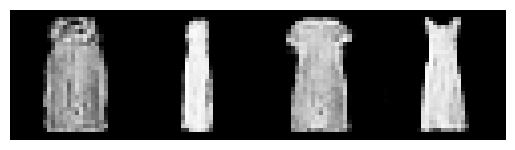

In [39]:
dc.generate_images(4, F.one_hot(torch.tensor([3]*4, device=device), num_classes=10).float())

In [51]:
dc2 = DCGAN('b', 100, 10, 1, 64, device)
dc2.train(traindataloader, 10, 64, 100)

----------- DCGAN Train Start! ------------
----------- Epoch #1 ------------
[100/1094] DLoss: 1.8706 GLoss:  1.5128, D(x): 0.8174 D(G(z)): 0.8115/0.2203
[200/1094] DLoss: 1.4065 GLoss:  0.7272, D(x): 0.5215 D(G(z)): 0.5301/0.4833
[300/1094] DLoss: 1.2475 GLoss:  0.8062, D(x): 0.5419 D(G(z)): 0.4648/0.4469
[400/1094] DLoss: 0.9271 GLoss:  1.5192, D(x): 0.6655 D(G(z)): 0.2161/0.2203
[500/1094] DLoss: 0.4487 GLoss:  2.7371, D(x): 0.7945 D(G(z)): 0.0758/0.0934
[600/1094] DLoss: 0.5881 GLoss:  1.8220, D(x): 0.7272 D(G(z)): 0.1602/0.1995
[700/1094] DLoss: 0.3690 GLoss:  3.0885, D(x): 0.9053 D(G(z)): 0.1376/0.0736
[800/1094] DLoss: 1.0654 GLoss:  1.5661, D(x): 0.8258 D(G(z)): 0.4986/0.2811
[900/1094] DLoss: 1.0484 GLoss:  1.5518, D(x): 0.4822 D(G(z)): 0.1209/0.3716
[1000/1094] DLoss: 0.6586 GLoss:  3.1775, D(x): 0.8591 D(G(z)): 0.2974/0.0769
----------- Epoch #2 ------------
[100/1094] DLoss: 1.0179 GLoss:  1.6473, D(x): 0.6507 D(G(z)): 0.3106/0.2627
[200/1094] DLoss: 0.9156 GLoss:  1.3275,

Discriminator Loss,████▆▃▄▂▂▁▆▆▆▄▆▄▅▅▆▇▅▅▅▆▇▆▄▄▅▃▃▅▄▃▃▇▃▃▅▂
Generator Loss,▁▃▃█▄▄▃▂▃▃▂▃▄▂▂▂▁▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂
Discriminator Loss,0.96828
Generator Loss,1.2846


In [52]:
torch.save(dc.generator.state_dict(), '/content/drive/MyDrive/DL3/dc_generator_arch_b.pth')
torch.save(dc.discriminator.state_dict(), '/content/drive/MyDrive/DL3/dc_discriminator_arch_b.pth')

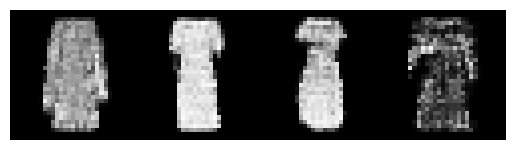

In [53]:
dc2.generate_images(4, F.one_hot(torch.tensor([3]*4, device=device), num_classes=10).float())

## WGAN with Clipping


In [61]:
def wasserstein_loss(real_preds, fake_preds):
    return torch.mean(fake_preds) - torch.mean(real_preds)

class WGAN:
    def __init__(self, arch_type, z_dim, channels, num_classes, features, device, clip_value=0.01, lr=0.00005):
        self.z_dim = z_dim
        self.clip_value = clip_value
        self.lr = lr
        self.device = device
        self.arch_type = arch_type
        self.model_type = 'clip'

        self.generator = Generator(self.model_type, self.arch_type, z_dim, num_classes, channels, features).to(device)
        self.critic = Discriminator(self.model_type, self.arch_type, channels, num_classes, features).to(device)
        self.loss = wasserstein_loss

        self.optim_critic = optim.RMSprop(self.critic.parameters(), lr=lr)
        self.optim_gen = optim.RMSprop(self.generator.parameters(), lr=lr)

    def train_critic(self, real_images, real_labels, fake_labels, batch_size):
        self.optim_critic.zero_grad()

        real_preds = self.critic(real_images, real_labels)

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images.detach(), fake_labels.detach())

        loss = self.loss(real_preds, fake_preds)
        loss.backward()
        self.optim_critic.step()

        for p in self.critic.parameters():
            p.data.clamp_(-self.clip_value, self.clip_value)

        return loss.item(), real_preds.mean().item(), fake_preds.mean().item()

    def train_generator(self, fake_labels, batch_size):
        self.optim_gen.zero_grad()

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images, fake_labels)

        loss = -torch.mean(fake_preds)
        loss.backward()
        self.optim_gen.step()

        return loss.item(), fake_images.mean().item()

    def train_one_epoch(self, dataloader, n_critic=5):
        for i, (real_images, real_labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            d_loss, avg_real, avg_fake1 = self.train_critic(real_images, real_labels, fake_labels, batch_size)

            if i % n_critic == 0:
                g_loss, avg_fake2 = self.train_generator(fake_labels, batch_size)
            else:
                g_loss, avg_fake2 = float('nan'), float('nan')

            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {d_loss:.4f}, Gloss: {g_loss:.4f}, C(x): {avg_real:.4f} C(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}")

            wandb.log({
                "Discriminator Loss": d_loss,
                "Generator Loss": g_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'clip_value': self.clip_value
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')

In [62]:
wandb.finish()

Discriminator Loss,▇▆▆▆█▄▄▅▃▃▃▃▃▂▃▃▁▂▁▂▂▁▂▁▁▂▂▂▂▁▂▂▂▂▂▁▂▂▃▃
Generator Loss,▁ █ ▇ █ █ ▇ ▆
Discriminator Loss,-0.01136
Generator Loss,nan


In [77]:
wgan = WGAN('a', 100, 1, 10, 64, device, lr=0.0001)
wgan.train(traindataloader, 10, 5)

----------- WGAN Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -0.0058, Gloss: -0.0066, C(x): 0.0132 C(G(z)): 0.0075/-0.1814
Batch 200/1094 Closs: -0.0056, Gloss: -0.0069, C(x): 0.0115 C(G(z)): 0.0060/-0.3306
Batch 300/1094 Closs: -0.0064, Gloss: -0.0062, C(x): 0.0125 C(G(z)): 0.0061/-0.3947
Batch 400/1094 Closs: -0.0053, Gloss: -0.0063, C(x): 0.0124 C(G(z)): 0.0071/-0.3979
Batch 500/1094 Closs: -0.0071, Gloss: -0.0069, C(x): 0.0123 C(G(z)): 0.0052/-0.3979
Batch 600/1094 Closs: -0.0065, Gloss: -0.0038, C(x): 0.0141 C(G(z)): 0.0077/-0.4042
Batch 700/1094 Closs: -0.0093, Gloss: -0.0048, C(x): 0.0132 C(G(z)): 0.0038/-0.4037
Batch 800/1094 Closs: -0.0109, Gloss: -0.0038, C(x): 0.0143 C(G(z)): 0.0034/-0.4089
Batch 900/1094 Closs: -0.0108, Gloss: -0.0044, C(x): 0.0139 C(G(z)): 0.0031/-0.3992
Batch 1000/1094 Closs: -0.0085, Gloss: -0.0028, C(x): 0.0150 C(G(z)): 0.0066/-0.4111
--------------------------------------
----------- Epoch #2 ------------
Batch 100

Discriminator Loss,██▇▇▇▂▁▁▂▁▁▂▁▂▁▂▂▂▂▃▃▃▁▃▃▂▃▃▃▃▄▂▂▃▂▃▃▂▂▃
Generator Loss,█ ▇ █ ▄ ▅ ▇ ▁ ▂▇
Discriminator Loss,-0.01047
Generator Loss,nan


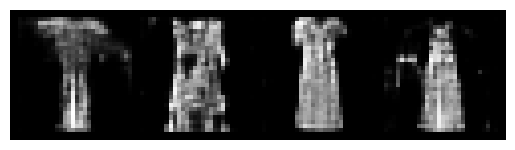

In [78]:
wgan.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgan.device), num_classes=10).float())

In [79]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_generator_arch_a.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_discriminator_arch_a.pth')

In [80]:
wgan2 = WGAN('b', 100, 1, 10, 64, device, lr=0.0001)
wgan2.train(traindataloader, 10, 5)

----------- WGAN Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -5.1329, Gloss: 54.3742, C(x): -47.2489 C(G(z)): -52.3818/-0.4362
Batch 200/1094 Closs: -35.8508, Gloss: 74.1412, C(x): -41.9501 C(G(z)): -77.8009/-0.4053
Batch 300/1094 Closs: -62.3774, Gloss: 156.9469, C(x): -94.5347 C(G(z)): -156.9120/-0.2130
Batch 400/1094 Closs: -64.6050, Gloss: 199.9543, C(x): -143.3925 C(G(z)): -207.9975/-0.3568
Batch 500/1094 Closs: -100.7006, Gloss: 251.0019, C(x): -139.7565 C(G(z)): -240.4571/-0.1662
Batch 600/1094 Closs: -85.8389, Gloss: 203.1243, C(x): -136.9632 C(G(z)): -222.8022/-0.2004
Batch 700/1094 Closs: -69.5835, Gloss: 192.6411, C(x): -128.9759 C(G(z)): -198.5594/-0.4607
Batch 800/1094 Closs: -1.1194, Gloss: 106.5062, C(x): -59.2165 C(G(z)): -60.3359/-0.1549
Batch 900/1094 Closs: -24.9121, Gloss: 108.4309, C(x): -98.2237 C(G(z)): -123.1359/-0.3059
Batch 1000/1094 Closs: -65.8727, Gloss: 227.7421, C(x): -149.2613 C(G(z)): -215.1340/-0.3615
-------------

Discriminator Loss,▁▄▅▃█▄▇▄▃▅▄▆▆▆▅▅▅▇▇▅▆▇▆▇▆▆▇▇▇█▇▇▇██▇▇█▇▇
Generator Loss,█ ▅ ▅ ▁▁ ▁ ▂ ▂▂
Discriminator Loss,-6.37142
Generator Loss,nan


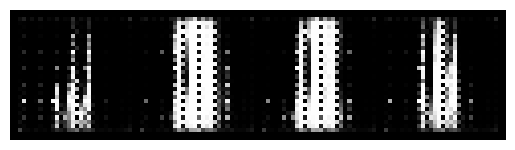

In [81]:
wgan2.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgan.device), num_classes=10).float())

In [82]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_generator_arch_b.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_discriminator_arch_b.pth')

## WGAN-GP

In [96]:
class WGAN_GP:
    def __init__(self, arch_type, z_dim, num_classes, channels, features, device, lr=0.0001, lambda_gp=10):
        self.z_dim = z_dim
        self.device = device
        self.lambda_gp = lambda_gp
        self.num_classes = num_classes
        self.lr = lr
        self.arch_type = arch_type
        self.model_type = 'gp'

        self.generator = Generator(self.model_type, arch_type, z_dim, num_classes, channels, features).to(device)
        self.critic = Discriminator(self.model_type, arch_type, channels, num_classes, features).to(device)

        self.optim_critic = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(0.0, 0.9))
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.0, 0.9))

    def compute_gradient_penalty(self, real_imgs, real_labels, fake_imgs):
        alpha = torch.rand((real_imgs.size(0), 1, 1, 1), device=self.device)
        interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        d_interpolates = self.critic(interpolates, real_labels)
        fake = torch.ones(d_interpolates.size(), device=self.device)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_critic(self, fake_labels, real_imgs, real_labels, batch_size):
        self.optim_critic.zero_grad()
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)

        fake_imgs = self.generator(noise, fake_labels)
        real_preds = self.critic(real_imgs, real_labels)
        fake_preds = self.critic(fake_imgs.detach(), fake_labels)
        gradient_penalty = self.compute_gradient_penalty(real_imgs, real_labels, fake_imgs.detach())
        critic_loss = -torch.mean(real_preds) + torch.mean(fake_preds) + self.lambda_gp * gradient_penalty
        critic_loss.backward()
        self.optim_critic.step()
        return critic_loss

    def train_generator(self, fake_labels):
        self.optim_gen.zero_grad()
        noise = torch.randn(fake_labels.size(0), self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_imgs, fake_labels)
        gen_loss = -torch.mean(fake_preds)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss

    def train_one_epoch(self, dataloader, n_critic):
        gen_loss = None  # Initialize gen_loss
        for i, (real_imgs, real_labels) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            # Train Critic n_critic times
            for _ in range(n_critic):
                critic_loss = self.train_critic(fake_labels, real_imgs, real_labels, batch_size)
            # Train Generator

            gen_loss = self.train_generator(fake_labels)
            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {critic_loss:.4f}, Gloss: {gen_loss:.4f}")

            wandb.log({
                "Critic Loss": critic_loss,
                "Generator Loss": gen_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan-GP', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'lambda_gp': self.lambda_gp
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')

In [97]:
wandb.finish()

In [92]:
wgangp = WGAN_GP('a', 100, 10, 1, 64, device)
wgangp.train(traindataloader, 10, 5)

----------- WGAN_GP Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -14.3090, Gloss: 8.0504
Batch 200/1094 Closs: -9.7446, Gloss: -1.7013
Batch 300/1094 Closs: -11.6021, Gloss: 8.2873
Batch 400/1094 Closs: -14.7538, Gloss: 20.1781
Batch 500/1094 Closs: -21.3046, Gloss: 4.0764
Batch 600/1094 Closs: -21.8121, Gloss: 16.1358
Batch 700/1094 Closs: 0.6259, Gloss: -9.6071
Batch 800/1094 Closs: -8.1833, Gloss: 17.3331
Batch 900/1094 Closs: -7.8457, Gloss: -10.8356
Batch 1000/1094 Closs: -0.9410, Gloss: -0.6002
--------------------------------------
----------- Epoch #2 ------------
Batch 100/1094 Closs: -15.2720, Gloss: 79.4280
Batch 200/1094 Closs: -36.3681, Gloss: 23.4275
Batch 300/1094 Closs: -25.8278, Gloss: 60.9625
Batch 400/1094 Closs: -36.5087, Gloss: 73.0523
Batch 500/1094 Closs: -55.2730, Gloss: 46.2590
Batch 600/1094 Closs: -13.4452, Gloss: 86.9694
Batch 700/1094 Closs: -0.2136, Gloss: 133.8481
Batch 800/1094 Closs: -13.3959, Gloss: 128.8626
Batch 9

Critic Loss,▇▆▇▇▇▇▆▆▆▆▅▇▆▆▇█▇▆█▄▆▆▅▅█▇▇▅▄▅▃▄█▅▅▆▂▁▂▇
Generator Loss,▄▄▄▄▄▄▄▄▅▃▄▄▄▄▄▄▄▅▅▄▄▃▃▆▄▄▅▅▆▄▅▄▇█▆▄▁▆▆▃
Critic Loss,-517.052
Generator Loss,390.81201


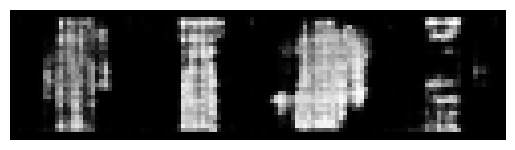

In [95]:
wgangp.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgangp.device), num_classes=10).float())

In [99]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_generator_arch_a.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_discriminator_arch_a.pth')

In [103]:
wgangp2 = WGAN_GP('b', 100, 10, 1, 64, device, lr=0.00001)
wgangp2.train(traindataloader, 10, 5)

----------- WGAN_GP Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -10.7736, Gloss: 25.4790
Batch 200/1094 Closs: -12.6708, Gloss: 19.3899
Batch 300/1094 Closs: -14.5690, Gloss: 2.6594
Batch 400/1094 Closs: -15.8027, Gloss: -2.0697
Batch 500/1094 Closs: -14.7076, Gloss: -3.2140
Batch 600/1094 Closs: -14.2537, Gloss: -8.3273
Batch 700/1094 Closs: -15.0878, Gloss: -11.6259
Batch 800/1094 Closs: -16.7405, Gloss: -12.0959
Batch 900/1094 Closs: -16.1320, Gloss: -13.3612
Batch 1000/1094 Closs: -15.7317, Gloss: -14.1735
--------------------------------------
----------- Epoch #2 ------------
Batch 100/1094 Closs: -14.3058, Gloss: -25.6745
Batch 200/1094 Closs: -12.4115, Gloss: -29.1571
Batch 300/1094 Closs: -11.8754, Gloss: -37.2898
Batch 400/1094 Closs: -12.3331, Gloss: -41.1078
Batch 500/1094 Closs: -14.3877, Gloss: -47.0274
Batch 600/1094 Closs: -16.9742, Gloss: -54.4378
Batch 700/1094 Closs: -13.3075, Gloss: -56.7203
Batch 800/1094 Closs: -12.7688, Gloss

Critic Loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▅▅▆▆▆▆▆▆▅▆▆▆▆▆▆▅▆▅▇▆▁█
Generator Loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▄▆▃▂▃▂▄▁▃▃██▅██▁▂
Critic Loss,90.53501
Generator Loss,639.4425


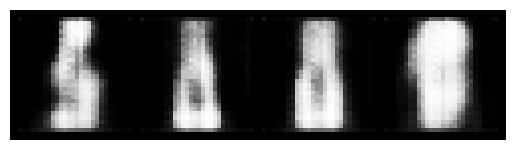

In [107]:
wgangp2.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgangp.device), num_classes=10).float())

In [108]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_generator_arch_b.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_discriminator_arch_b.pth')